# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
* the date of departure
* the departure airport
* the arrival airport
* the mean and standard deviation of the number of weeks of the reservations made before the departure date
* a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. **The challenge in this RAMP is to find good data that can be correlated to flight traffic**.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [1]:
!pip help install


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

Description:
  Install packages from:
  
  - PyPI (and other indexes) using requirement specifiers.
  - VCS project urls.
  - Local project directories.
  - Local or remote source archives.
  
  pip also supports installing from "requirements files", which provide
  an easy way to specify a whole environment to be installed.

Install Options:
  -c, --constraint <file>     Constrain versions using the given constraints
                              file. This option can be used multiple times.
  -e, --editable <path/url>   Install a project in editable mode (i.e.
                              setuptools "develop mode") from a local project
                              path or 

In [2]:
!pip install -U --force-reinstall seaborn  # if you don't have it, or pip3 for python3

Exception:
Traceback (most recent call last):
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pip\basecommand.py", line 211, in main
    status = self.run(options, args)
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pip\commands\install.py", line 282, in run
    wheel_cache
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pip\basecommand.py", line 272, in populate_requirement_set
    wheel_cache=wheel_cache
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pip\req\req_install.py", line 213, in from_line
    wheel_cache=wheel_cache, constraint=constraint)
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pip\req\req_install.py", line 67, in __init__
    req = pkg_resources.Requirement.parse(req)
  File "C:\Users\Hugo\Telecom\4A\WinPython-64bit-2.7.10.3\p

In [2]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [3]:
data = pd.read_csv("C:/Users/Hugo/Desktop/Telecom/4A/Data Camp/Air passenger prediction/public_train.csv",index_col=0)

In [4]:
data = pd.read_csv("C:/Users/Hugo/Desktop/Telecom/4A/Data Camp/Air passenger prediction/public_train.csv")

In [5]:
print min(data['DateOfDeparture'])
print max(data['DateOfDeparture'])


2011-09-01
2013-03-05


In [6]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662


In [7]:
data['Departure'].unique()

array(['DFW', 'LAX', 'ORD', 'DEN', 'MCO', 'IAH', 'MIA', 'ATL', 'LGA',
       'SEA', 'PHX', 'CLT', 'DTW', 'LAS', 'EWR', 'MSP', 'BOS', 'PHL',
       'SFO', 'JFK'], dtype=object)

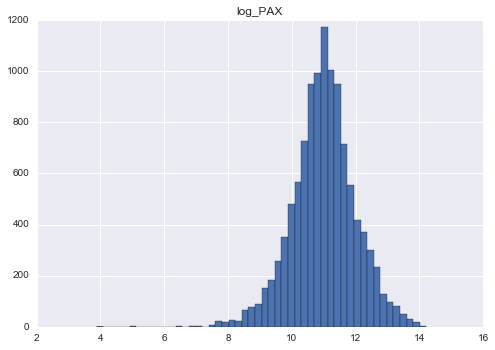

In [8]:
data.hist(column='log_PAX', bins=50);

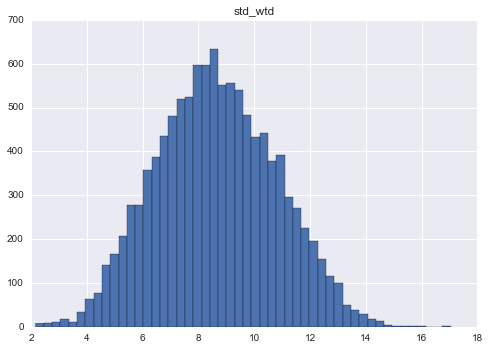

In [9]:
data.hist('std_wtd', bins=50);

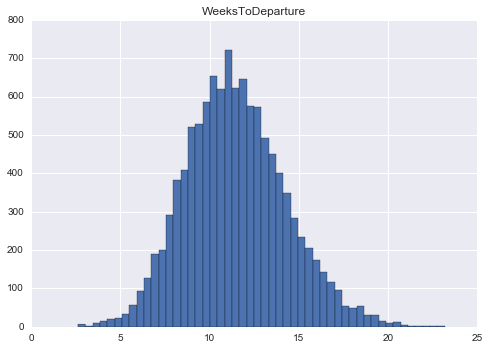

In [10]:
data.hist('WeeksToDeparture', bins=50);

In [11]:
data.describe()

,WeeksToDeparture,log_PAX,std_wtd
count,11128.000000,11128.000000,11128.000000
mean,11.466842,10.997728,8.635226
std,2.807131,0.998242,2.145805
min,2.625000,3.878108,2.160247
25%,9.523810,10.427055,7.109619
50%,11.304348,11.008268,8.582272
75%,13.259259,11.590093,10.162525
max,23.163265,14.224277,17.035677


In [12]:
data.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAX             float64
std_wtd             float64
dtype: object

In [13]:
data.shape

(11128, 6)

In [14]:
print data['log_PAX'].mean()
print data['log_PAX'].std()

10.9977280345
0.99824195459


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [15]:
data_encoded = data

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
data_encoded = data_encoded.drop('Departure', axis=1)
data_encoded = data_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))

In [16]:
data_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
11123,2011-11-22,11.636364,10.334322,8.888438,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2011,11,22,1,47,15300,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11124,2011-12-14,13.541667,12.459632,10.341891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,12,14,2,50,15322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11125,2013-01-28,5.583333,11.381124,3.752777,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2013,1,28,0,5,15733,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11126,2011-09-03,12.730769,11.308812,7.997788,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2011,9,3,5,35,15220,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11127,2012-09-24,14.250000,11.619697,9.508768,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2012,9,24,0,39,15607,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### A linear regressor baseline

We drop the target column and the original data column.

In [17]:
features = data_encoded.drop(['log_PAX','DateOfDeparture'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX','DateOfDeparture'])
X = features.values
y = data_encoded['log_PAX'].values

In [33]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

It gives us a pretty nice imporvement above baseline

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.6393 +/-0.0259


Exercise: Visualize the coefficients, try to make sense of them.

## Random Forests

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=1)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

## Variable importances

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
len(X_columns)

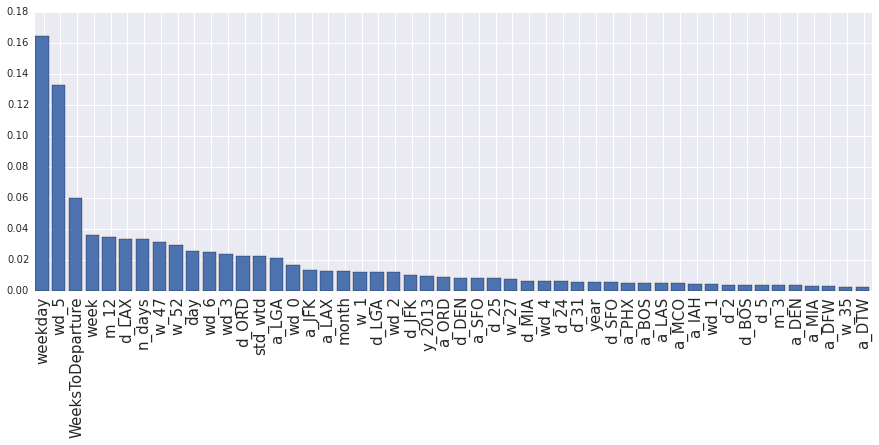

In [62]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

# Submission

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function. 


You can choose one of the example feature extractors and copy-paste it into your feature_extractor.py file.

In [18]:
class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array

This feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save is as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

In [25]:
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        # path = os.path.dirname(__file__)  # use this in submission
        path = '.'  # use this in notebook
        data_weather = pd.read_csv(os.path.join(path, "C:/Users/Hugo/Desktop/Telecom/4A/Data Camp/Air passenger prediction/external_data.csv"))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = X_encoded.set_index(['DateOfDeparture', 'Arrival'])
        X_weather = X_weather.set_index(['DateOfDeparture', 'Arrival'])
        X_encoded = X_encoded.join(X_weather).reset_index()

        X_encoded = X_encoded.join(pd.get_dummies(
            X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(
            pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array

### The regressor

The regressor should implement an sklearn-like regressor with fit and predict functions. You can copy paste either of these into your first regressor.py file.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestRegressor(n_estimators=10, max_depth=10, max_features=10)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = LinearRegression()

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

Let's put it together and run the chain.

In [29]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit


def train_model(X_df, y_array, skf_is):
    fe = FeatureExtractor()
    fe.fit(X_df, y_array)
    X_array = fe.transform(X_df)
    # Regression
    train_is, _ = skf_is
    X_train_array = np.array([X_array[i] for i in train_is])
    y_train_array = np.array([y_array[i] for i in train_is])
    reg = Regressor()
    reg.fit(X_train_array, y_train_array)
    return fe, reg


def test_model(trained_model, X_df, skf_is):
    fe, reg = trained_model
    # Feature extraction
    X_array = fe.transform(X_df)
    # Regression
    _, test_is = skf_is
    X_test_array = np.array([X_array[i] for i in test_is])
    y_pred_array = reg.predict(X_test_array)
    return y_pred_array


data = pd.read_csv("C:/Users/Hugo/Desktop/Telecom/4A/Data Camp/Air passenger prediction/public_train.csv")
X_df = data.drop(['log_PAX'], axis=1)
y_array = data['log_PAX'].values

skf = ShuffleSplit(y_array.shape[0], n_iter=2, test_size=0.2, random_state=61)
skf_is = list(skf)[0]

trained_model = train_model(X_df, y_array, skf_is)
y_pred_array = test_model(trained_model, X_df, skf_is)
_, test_is = skf_is
ground_truth_array = y_array[test_is]

score = np.sqrt(np.mean(np.square(ground_truth_array - y_pred_array)))
print 'RMSE =', score

RMSE = 0.996463751934


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>regressor.py</code>, <code>feature_extractor.py</code>, <code>external_data.csv</code> and <a href="https://drive.google.com/file/d/0BzwKr6zuOkdRdUN2WEtuZlVHUmM/view?usp=sharing"><code>user_test_model.py</code></a> in a directory, set the paths to the data files in <code>user_test_model.py</code>, and run 

<code>python user_test_model.py</code>

If it runs and prints 
<code>
RMSE = [some_number_hopefully_below_1]
</code>
you can submit the code.